# One layer model

Here we show how to run our two-layer model as a single-layer model. Put simply, we make the deep ocean component of the two-layer model infinitely deep and we have a single layer model. The concept is described by Equation 4 of [Geoffroy et al. 2013, Part 1](https://journals.ametsoc.org/doi/10.1175/JCLI-D-12-00195.1).

In [1]:
# NBVAL_IGNORE_OUTPUT
import os.path

import numpy as np
import pandas as pd
import openscm_units.unit_registry as ur
import tqdm.autonotebook as tqdman
from scmdata import ScmRun

from openscm_twolayermodel import TwoLayerModel

import matplotlib.pyplot as plt

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


For this we use RCMIP effective radiative forcing data.

In [2]:
DATA_PATH = os.path.join(
    "..",
    "tests",
    "test-data",
    "rcmip-radiative-forcing-annual-means-v4-0-0.csv",
)
DATA_PATH

'../tests/test-data/rcmip-radiative-forcing-annual-means-v4-0-0.csv'

In [3]:
# NBVAL_IGNORE_OUTPUT
scenarios = ScmRun(DATA_PATH).filter(scenario="historical", keep=False)
scenarios

<scmdata.ScmRun (timeseries: 480, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	           model          scenario region  \
	0            AIM             rcp60  World   
	1            AIM             rcp60  World   
	2            AIM             rcp60  World   
	3            AIM             rcp60  World   
	4            AIM             rcp60  World   
	..           ...               ...    ...   
	494  unspecified  historical-cmip5  World   
	495  unspecified  historical-cmip5  World   
	496  unspecified  historical-cmip5  World   
	497  unspecified  historical-cmip5  World   
	498  unspecified  historical-cmip5  World   
	
	                                              variable   unit     activity_id  \
	0                                    Radiative Forcing  W/m^2  not_applicable   
	1                      Radiative Forcing|Anthropogenic  W/m^2  not_applicable   
	2             Radiative Forcing|Anthropogenic|Aerosols  W/m^2  not_applicable   


In [4]:
dl_values = np.array([2000, 10000, 10**15]) * ur("m")
dl_values

array([            2000,            10000, 1000000000000000]) <Unit('meter')>

In [5]:
def df_append(inp):
    # TODO: ask Jared why this hack is needed
    tmp = pd.concat([i.timeseries().reset_index() for i in inp], axis=0,)

    def is_time(x):
        try:
            x.year
            return True
        except AttributeError:
            return False

    time_cols = tmp.columns.map(lambda x: hasattr(x, "year"))
    meta_cols = tmp.columns[~(time_cols.values.astype(bool))].tolist()
    tmp = tmp.set_index(meta_cols)

    return ScmRun(tmp)

In [6]:
# NBVAL_IGNORE_OUTPUT
runner = TwoLayerModel()
output = []
equivalent_parameters = []
for dl in tqdman.tqdm(dl_values, desc="Parameter settings"):
    runner.dl = dl
    output.append(runner.run_scenarios(scenarios))
    equivalent_parameters.append(({"two-layer deep ocean depth": runner.dl}, runner.get_impulse_response_parameters()))

output = df_append(output)
output

<scmdata.ScmRun (timeseries: 120, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	             model                   scenario region  \
	799        AIM/CGE                     ssp370  World   
	800        AIM/CGE                     ssp370  World   
	801        AIM/CGE                     ssp370  World   
	802        AIM/CGE                     ssp370  World   
	803        AIM/CGE  ssp370-lowNTCF-aerchemmip  World   
	..             ...                        ...    ...   
	914  REMIND-MAGPIE                ssp534-over  World   
	915  REMIND-MAGPIE                     ssp585  World   
	916  REMIND-MAGPIE                     ssp585  World   
	917  REMIND-MAGPIE                     ssp585  World   
	918  REMIND-MAGPIE                     ssp585  World   
	
	                        variable        unit  \
	799  Effective Radiative Forcing       W/m^2   
	800    Surface Temperature|Upper  delta_degC   
	801    Surface Temperature|Lower  delta_degC   


As we can see in the plots below, as the deep ocean becomes bigger, it can uptake more heat and hence warming is reduced. We also see that the deeper the deep ocean is, the faster the temperature response.  This is because there is effectively only one timescale in such a model (as discussed in [Geoffroy et al. 2013, Part 1](https://journals.ametsoc.org/doi/10.1175/JCLI-D-12-00195.1)), the slow, long-timescale response effectively disappears. This is clear if we look at the slow-timescale in the equivalent two-timescale response parameters. As the deep ocean becomes bigger and bigger, the slow-timescale grows from hundreds to thousands to billions of years.

In [7]:
for v in equivalent_parameters:
    v[1]["d1"] = v[1]["d1"].to("yr")
    v[1]["d2"] = v[1]["d2"].to("yr")
    
equivalent_parameters

[({'two-layer deep ocean depth': 2000 <Unit('meter')>},
  {'d1': 3.224285795910259 <Unit('a')>,
   'd2': 545.8565630896654 <Unit('a')>,
   'q1': 0.4848549694209551 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.31728406801220327 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'efficacy': 1.0 <Unit('dimensionless')>}),
 ({'two-layer deep ocean depth': 10000 <Unit('meter')>},
  {'d1': 3.2342013046041056 <Unit('a')>,
   'd2': 2720.915300585768 <Unit('a')>,
   'q1': 0.4878523568580023 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.3142866805751838 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'efficacy': 1.0 <Unit('dimensionless')>}),
 ({'two-layer deep ocean depth': 1000000000000000 <Unit('meter')>},
  {'d1': 3.238959349323281 <Unit('a')>,
   'd2': 271883581625601.66 <Unit('a')>,
   'q1': 0.4889441930744013 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.31555972744518723 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   

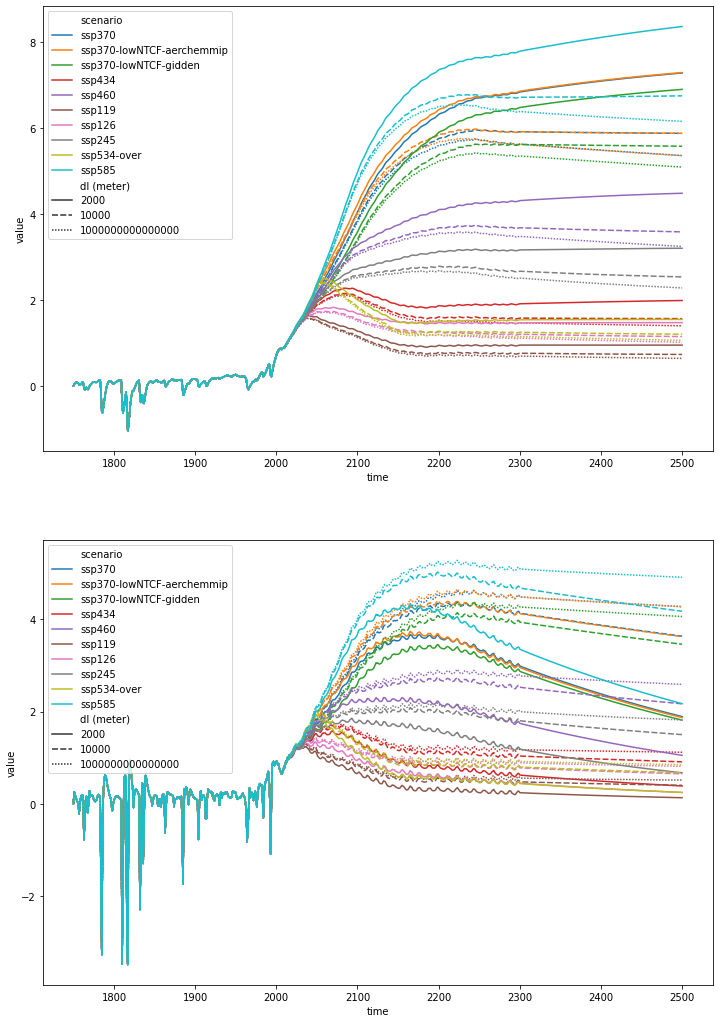

In [8]:
# NBVAL_IGNORE_OUTPUT
pkwargs = dict(
    hue="scenario", style="dl (meter)",
)
fig = plt.figure(figsize=(12, 18))

ax = fig.add_subplot(211)
output.filter(variable="Surface Temperature|Upper").lineplot(**pkwargs, ax=ax)

ax = fig.add_subplot(212)
output.filter(variable="Heat Uptake").lineplot(**pkwargs, ax=ax)